# Pipeline
### Prepare data

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                 'machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data',
                 header = None)

In [2]:
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [3]:
le.transform(['M', 'B'])

array([1, 0])

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    stratify = y,
                                                    random_state = 1)

### construct pipeline
- train, test를 각각 변환하지 않고 파이프라인으로 연결할 수 있다.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components = 2),
                        LogisticRegression(solver = 'liblinear', random_state = 1))
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
print(f"테스트 정확도 : {pipe_lr.score(X_test, y_test)}")

테스트 정확도 : 0.956140350877193


- pipeline클래스로 변환기와 추정기를 감싼 wrapper로 생각할 수 있다.
- pipeline의 마지막 요소는 추정기가 돼야 한다.
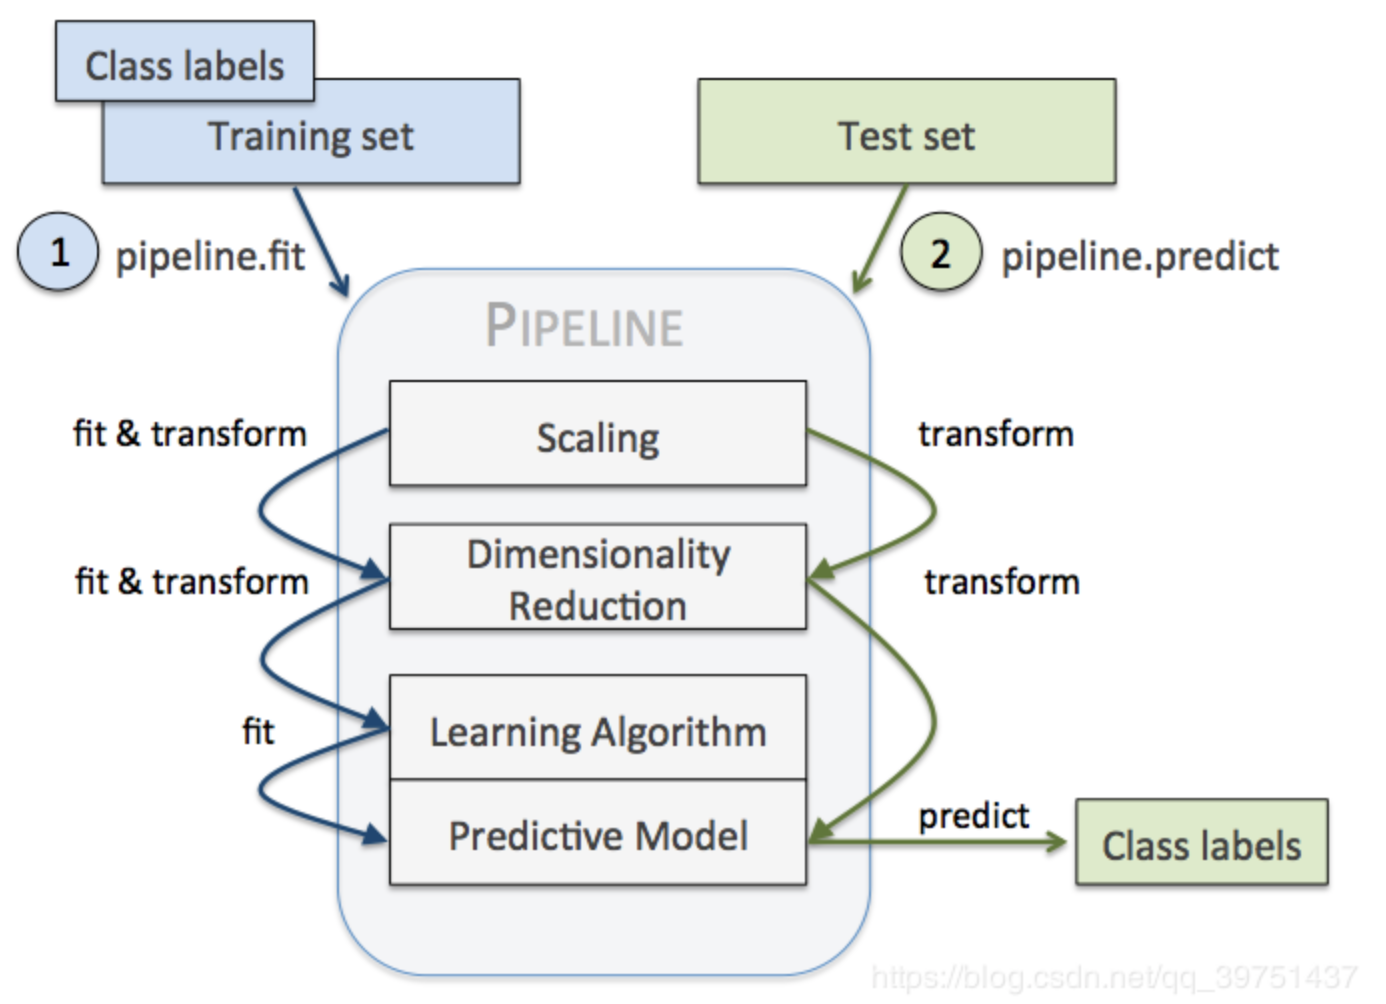

# KFold cross-validation

In [8]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits = 10, random_state = 1, shuffle = True).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f"폴드: {k+1}, 클래스 분포: {np.bincount(y_train[train])}, 정확도: {round(score, 3)}")

print(f"CV 정확도: {np.mean(scores)} +/- {np.std(scores)}")

폴드: 1, 클래스 분포: [256 153], 정확도: 0.913
폴드: 2, 클래스 분포: [256 153], 정확도: 1.0
폴드: 3, 클래스 분포: [256 153], 정확도: 0.957
폴드: 4, 클래스 분포: [256 153], 정확도: 0.978
폴드: 5, 클래스 분포: [256 153], 정확도: 0.87
폴드: 6, 클래스 분포: [257 153], 정확도: 0.933
폴드: 7, 클래스 분포: [257 153], 정확도: 0.956
폴드: 8, 클래스 분포: [257 153], 정확도: 0.978
폴드: 9, 클래스 분포: [257 153], 정확도: 0.978
폴드: 10, 클래스 분포: [257 153], 정확도: 0.911
CV 정확도: 0.9472946859903383 +/- 0.03803650729783967


# KFold cross_val_score

In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator = pipe_lr, X = X_train,
                         y = y_train, cv = 10, n_jobs = -1)

print(f"CV 정확도 점수 : {scores}")
print(f"CV 정확도: {np.mean(scores)} +/- {np.std(scores)}")

CV 정확도 점수 : [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.9495169082125603 +/- 0.013854294239660376


In [11]:
from sklearn.model_selection import cross_validate

scores = cross_validate(estimator = pipe_lr, X = X_train,
                        y = y_train, scoring = ['accuracy'],
                        cv = 10, n_jobs = -1, return_train_score = False)
print(f"CV 정확도 점수 : {scores['test_accuracy']}")
print(f"CV 정확도: {np.mean(scores['test_accuracy'])} +/- {np.std(scores['test_accuracy'])}")

CV 정확도 점수 : [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV 정확도: 0.9495169082125603 +/- 0.013854294239660376


# 학습 곡선과 검증 곡선
- 그래프를 통해 분산과 편향의 문제점을 확인할 수 있다.

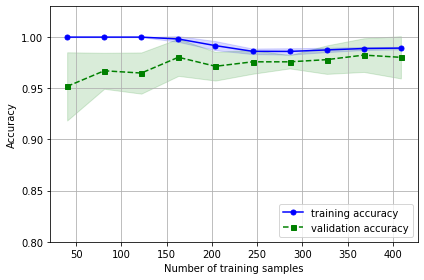

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(solver = 'liblinear',
                                           penalty = 'l2',
                                           random_state = 1))

train_sizes, train_scores, test_scores = learning_curve(estimator = pipe_lr,
                                                        X = X_train,
                                                        y = y_train,
                                                        # linspace로 일정간격 훈련세트의 비율선택
                                                        train_sizes = np.linspace(
                                                        0.1, 1.0, 10),
                                                        cv = 10,
                                                        n_jobs = 1)
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_mean,
         color = 'blue', marker = 'o',
         markersize = 5, label = 'training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')

plt.plot(train_sizes, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# 검증 곡선으로 과대적합 과소적합 검사
- 검증곡선은 훈련, 테스트 정확도 대신에 모델 파라미터 값의 함수로 그린다.

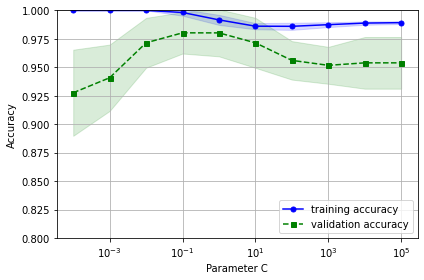

In [21]:
# logistic regression's hyper-parameter : C
from sklearn.model_selection import validation_curve

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]
trian_scores, test_scores = validation_curve(estimator = pipe_lr,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'logisticregression__C',
                                             param_range = param_range,
                                             cv = 10)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.plot(param_range, train_mean,
         color = 'blue', marker = 'o',
         markersize = 5, label = 'training accuracy')

plt.fill_between(param_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha = 0.15, color = 'blue')

plt.plot(param_range, test_mean,
         color = 'green', linestyle = '--',
         marker = 's', markersize = 5,
         label = 'validation accuracy')

plt.fill_between(param_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha = 0.15, color = 'green')

plt.grid()
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

- validation curve 함수 안에 평가하고자 하는 매개변수를 지정
- param_range : 매개변수에는 값 범위 지정

# Gridsearch
- 리스트로 지정된 여러 가지 hyper-parameter값 전체를 조사한다.

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state = 1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C':param_range,
               'svc__kernel':['linear']},
              {'svc__C':param_range,
               'svc__gamma':param_range,
               'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = -1)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [24]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print(f"테스트 정확도 : {round(clf.score(X_test, y_test), 3)}")

테스트 정확도 : 0.974


# 중첩 교차 검증

In [26]:
gs = GridSearchCV(estimator = pipe_svc,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 2)

scores = cross_val_score(gs, X_train, y_train,
                         scoring = 'accuracy', cv = 5)
print("cv 정확도 : ", np.mean(scores), np.std(scores))

cv 정확도 :  0.9736263736263737 0.014906219743132467
